In [1]:
import sys,os,math,string,time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from pyzillow.pyzillow import ZillowWrapper, GetDeepSearchResults
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import ensemble, tree, linear_model
import seaborn as sns
import scipy.stats as st
import missingno as msno
import pickle
pd.options.display.max_rows = 200

%matplotlib inline 

In [2]:
df = pd.read_csv("downsized_6.csv")
df = df.drop(columns=["Unnamed: 0"],axis=1)

In [3]:
df.columns

Index(['key', 'PID', 'ST_NUM', 'ST_NAME', 'ST_NAME_SUF', 'ZIPCODE', 'PTYPE',
       'LU', 'OWN_OCC', 'AV_BLDG', 'AV_TOTAL', 'GROSS_TAX', 'LAND_SF',
       'YR_BUILT', 'YR_REMOD', 'GROSS_AREA', 'LIVING_AREA', 'NUM_FLOORS',
       'R_BLDG_STYL', 'R_ROOF_TYP', 'R_EXT_FIN', 'R_TOTAL_RMS', 'R_BDRMS',
       'R_FULL_BTH', 'R_HALF_BTH', 'R_BTH_STYLE', 'R_KITCH', 'R_KITCH_STYLE',
       'R_HEAT_TYP', 'R_AC', 'R_FPLACE', 'R_EXT_CND', 'R_OVRALL_CND',
       'R_INT_CND', 'R_INT_FIN', 'R_VIEW', 'FULLADD', 'R_TOTAL_BTH',
       'MARKET_VALUE', 'DIFF_MV', 'DIFF_TAX', 'Lattitude', 'Longitude',
       'LatLon', 'DIS0', 'DIS1', 'DIS2', 'DIS3', 'DIS4', 'DIS5'],
      dtype='object')

In [4]:
df = df.drop(columns=["DIFF_TAX","DIFF_MV","Lattitude","Longitude","LatLon"],axis=1)

In [5]:
df = df[df["DIS0"]<100]
df["DIS0"] = np.log(df["DIS0"])
df["DIS1"] = np.log(df["DIS1"])
df["DIS2"] = np.log(df["DIS2"])
df["DIS3"] = np.log(df["DIS3"])
df["DIS4"] = np.log(df["DIS4"])

df["MARKET_VALUE"] = np.log(df["MARKET_VALUE"])
df["GROSS_AREA"] = np.log(df["GROSS_AREA"])
df["LIVING_AREA"] = np.log(df["LIVING_AREA"])
df["YR_REMOD"] = df["YR_REMOD"].fillna(value=0.0); 
df['OWN_OCC'] = df['OWN_OCC'].map({'Y': 1, 'N': 0})
df["key"] = pd.to_numeric(df["key"], errors='ignore')
df = df.dropna(); 
print(len(df))

28408


In [6]:
for feat in df.columns: 
    temper = df[df[feat].isna()]
    if(len(temper)>0): 
        print(feat, len(temper))

In [7]:
def mybarplot(xfeat,yfeat,df,xlabel,ylabel):
    plt.figure(figsize=(12,4));
    ax = sns.boxplot(x=xfeat, y=yfeat, data=df);

    plt.xticks(size=18,rotation=90)
    plt.yticks(size=18)
    plt.xlabel(xlabel,size=18,labelpad=20)
    plt.ylabel(ylabel,size=18,labelpad=20)


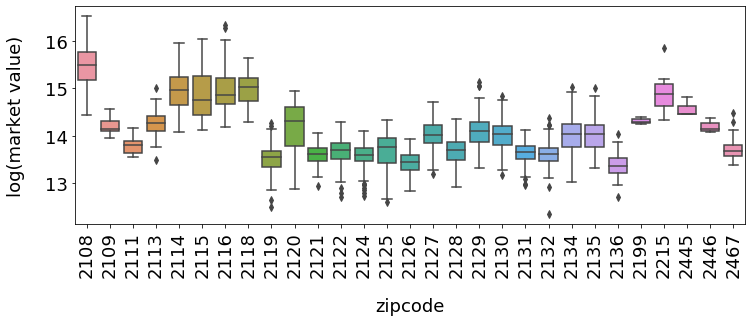

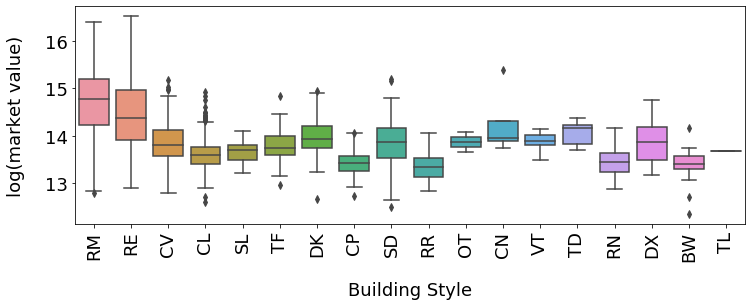

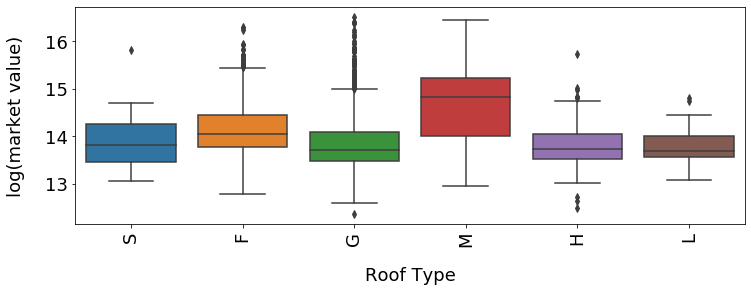

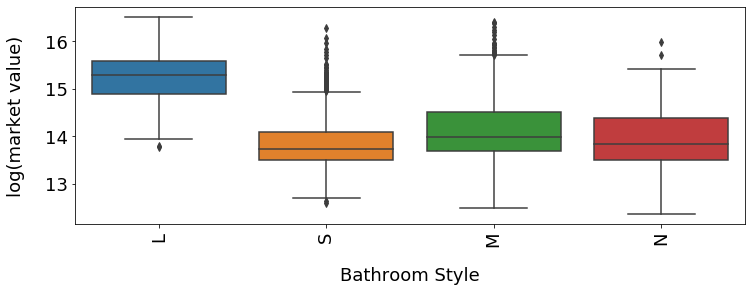

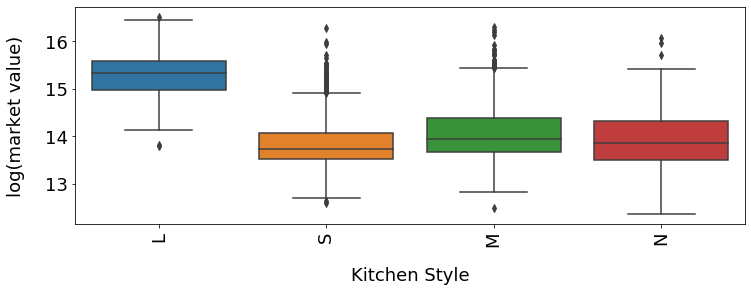

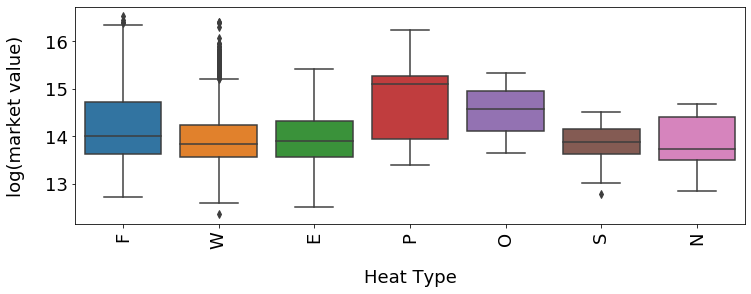

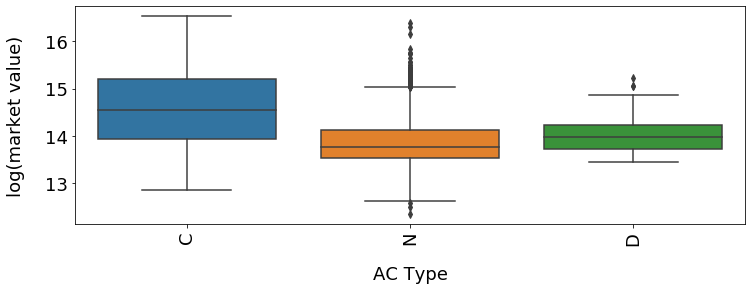

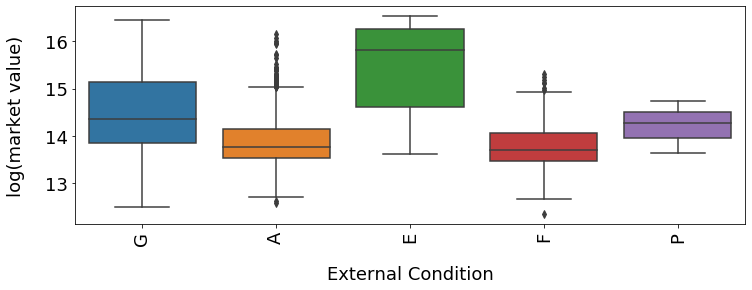

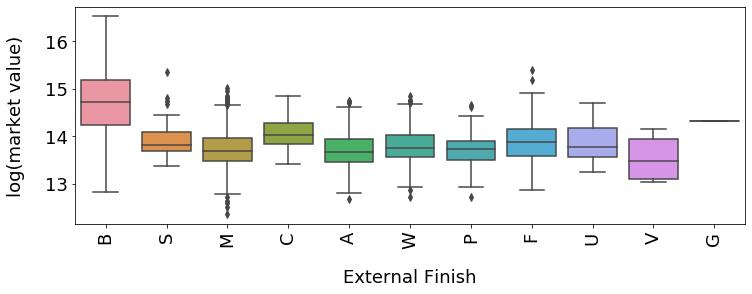

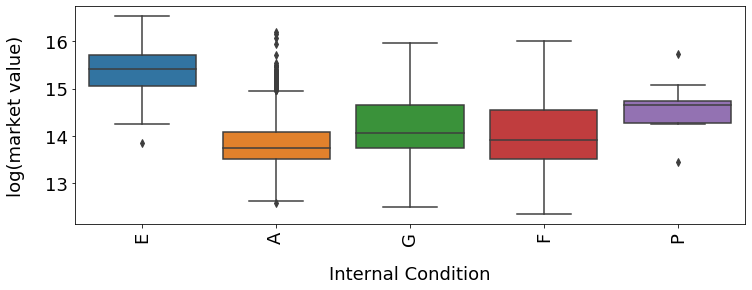

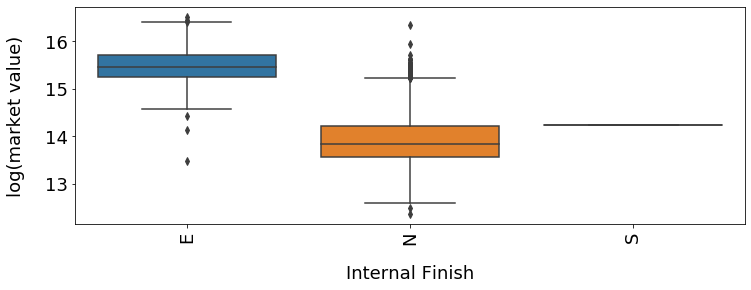

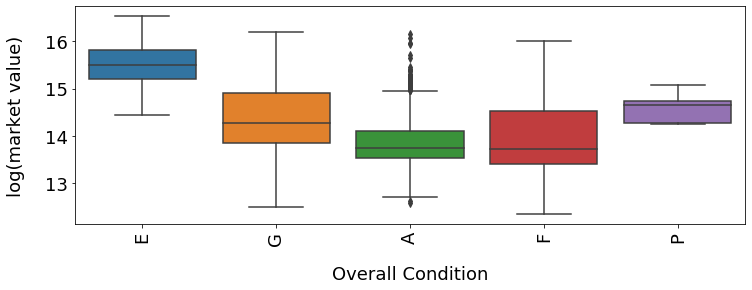

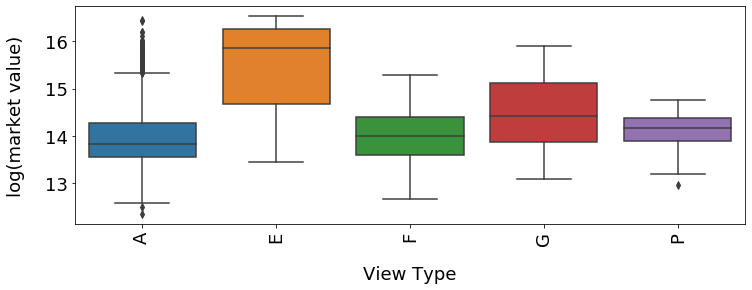

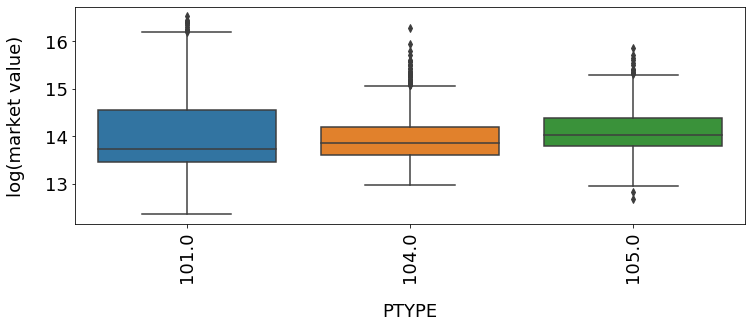

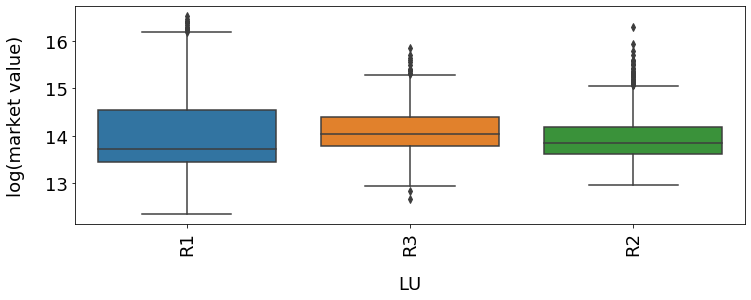

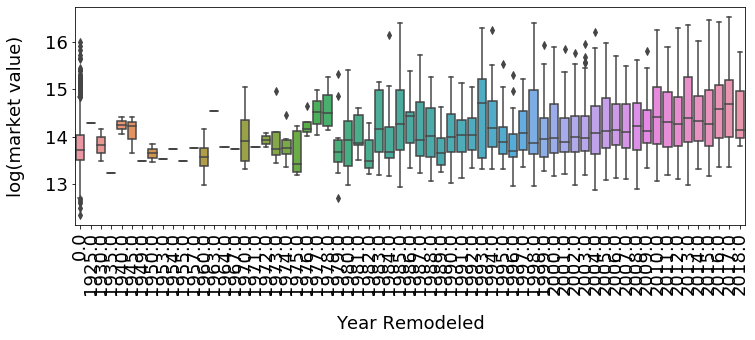

In [8]:
df2019 = df[df["key"]==2019]
mybarplot("ZIPCODE","MARKET_VALUE",df2019,"zipcode", "log(market value)")
mybarplot("R_BLDG_STYL","MARKET_VALUE",df2019,"Building Style", "log(market value)")
mybarplot("R_ROOF_TYP","MARKET_VALUE",df2019,"Roof Type", "log(market value)")
mybarplot("R_BTH_STYLE","MARKET_VALUE",df2019,"Bathroom Style", "log(market value)")
mybarplot("R_KITCH_STYLE","MARKET_VALUE",df2019,"Kitchen Style", "log(market value)")
mybarplot("R_HEAT_TYP","MARKET_VALUE",df2019,"Heat Type", "log(market value)")
mybarplot("R_AC","MARKET_VALUE",df2019,"AC Type", "log(market value)")
mybarplot("R_EXT_CND","MARKET_VALUE",df2019,"External Condition", "log(market value)")
mybarplot("R_EXT_FIN","MARKET_VALUE",df2019,"External Finish", "log(market value)")
mybarplot("R_INT_CND","MARKET_VALUE",df2019,"Internal Condition", "log(market value)")
mybarplot("R_INT_FIN","MARKET_VALUE",df2019,"Internal Finish", "log(market value)")
mybarplot("R_OVRALL_CND","MARKET_VALUE",df2019,"Overall Condition", "log(market value)")
mybarplot("R_VIEW","MARKET_VALUE",df2019,"View Type", "log(market value)")
mybarplot("PTYPE","MARKET_VALUE",df2019,"PTYPE", "log(market value)")
mybarplot("LU","MARKET_VALUE",df2019,"LU", "log(market value)")
mybarplot("YR_REMOD","MARKET_VALUE",df2019,"Year Remodeled", "log(market value)")

# Feature engineering

<h3> Average market-value per zipcode </h3>

In [9]:
Zips = pd.unique(df["ZIPCODE"])
Years = pd.unique(df["key"])
df["ZIP_MV"] = 0
df2 = pd.DataFrame(columns=df.columns)
for zv in Zips: 
    temper2 = df[df["ZIPCODE"]==zv]; 
    temper2["ZIP_MV"] = temper2["MARKET_VALUE"].mean()
    df2 = df2.append(temper2)

print(len(df2))

/home/npatel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


28408


In [10]:
df2.to_csv("downsized_7.csv",index=False)

In [11]:
# collect features to be used for training, still need to do one-hot
myfeat = ['key', 'PTYPE',
       'LU', 'OWN_OCC', 'LAND_SF', 'YR_BUILT', 'YR_REMOD', 'GROSS_AREA', 'LIVING_AREA', 'NUM_FLOORS',
       'R_BLDG_STYL', 'R_ROOF_TYP', 'R_EXT_FIN', 'R_TOTAL_RMS', 'R_BDRMS',
       'R_FULL_BTH', 'R_HALF_BTH', 'R_BTH_STYLE', 'R_KITCH', 'R_KITCH_STYLE',
       'R_HEAT_TYP', 'R_AC', 'R_FPLACE', 'R_EXT_CND', 'R_OVRALL_CND',
       'R_INT_CND', 'R_INT_FIN', 'R_VIEW', 'R_TOTAL_BTH','MARKET_VALUE', "ZIP_MV",
        'DIS0', 'DIS1', 'DIS2', 'DIS3', 'DIS4', 'DIS5']
data = df2[myfeat]

In [12]:
# convert year to numeric value
data["key"] = pd.to_numeric(data["key"], errors='ignore')
data = pd.get_dummies(data)

/home/npatel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
all_features = data.columns
index = np.argwhere(all_features=="MARKET_VALUE")
all_features = np.delete(all_features, index)
target_feature = "MARKET_VALUE"

In [14]:
data.columns

Index(['key', 'PTYPE', 'LAND_SF', 'YR_BUILT', 'YR_REMOD', 'GROSS_AREA',
       'LIVING_AREA', 'NUM_FLOORS', 'R_TOTAL_RMS', 'R_BDRMS',
       ...
       'R_INT_CND_G', 'R_INT_CND_P', 'R_INT_FIN_E', 'R_INT_FIN_N',
       'R_INT_FIN_S', 'R_VIEW_A', 'R_VIEW_E', 'R_VIEW_F', 'R_VIEW_G',
       'R_VIEW_P'],
      dtype='object', length=106)

In [15]:
# making sure there are no nan 
for feat in data.columns: 
    temper = data[data[feat].isna()]
    if(len(temper)>0): 
        print(feat, len(temper))

# Data Setup for Modeling

In [16]:
# keeping all the 2019 data into test-set 
data19 = data[data["key"]==2019]
data18 = data[data["key"]!=2019]

# 80/20 test train split on 2010-2018 data. 
X_train, X_test, Y_train, Y_test = train_test_split(data18[all_features], data18[target_feature], test_size=0.2, random_state=1)

# append 2019 test data into X_test and Y_test
X_test = X_test.append(data19[all_features]);
Y_test = Y_test.append(data19[target_feature]); 

# ElasticNet 

In [17]:
from sklearn.linear_model import ElasticNetCV
pd.options.display.max_rows = 200

# Reduced eps to 10^-4 
# Remember to always normalize!
ElasticNetCVModel2 = ElasticNetCV(l1_ratio=[1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1], 
                                  eps=0.0001, n_alphas=50, normalize=True, random_state=1,
                                  verbose=True, max_iter=1000)

# Fitting on train data with cross-validation.  
ElasticNetCVModel2.fit(X_train,Y_train)

/home/npatel/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.0001,
             fit_intercept=True,
             l1_ratio=[1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1],
             max_iter=1000, n_alphas=50, n_jobs=None, normalize=True,
             positive=False, precompute='auto', random_state=1,
             selection='cyclic', tol=0.0001, verbose=True)

In [18]:
# does the weights make sense? - Looks reasonable
# L1 reguralization is working well for feature importance!
coef_val = pd.Series(ElasticNetCVModel2.coef_,all_features)
print(coef_val.sort_values(ascending=False))

ZIP_MV             0.770414
LIVING_AREA        0.294363
R_VIEW_E           0.226652
R_EXT_FIN_G        0.199178
GROSS_AREA         0.154395
R_BLDG_STYL_OT     0.111451
R_BLDG_STYL_TD     0.100535
R_VIEW_G           0.097128
R_INT_FIN_E        0.096280
DIS5               0.093247
R_INT_CND_E        0.090322
R_BLDG_STYL_CN     0.075709
R_BLDG_STYL_SL     0.055734
R_EXT_FIN_C        0.052737
R_BLDG_STYL_RE     0.047852
R_ROOF_TYP_M       0.043079
R_HEAT_TYP_P       0.040918
DIS2               0.037439
R_BLDG_STYL_RN     0.035747
key                0.034365
R_EXT_FIN_S        0.034154
NUM_FLOORS         0.033163
R_BLDG_STYL_RM     0.031816
R_TOTAL_BTH        0.030433
R_EXT_FIN_W        0.025627
R_KITCH_STYLE_M    0.023838
R_EXT_FIN_V        0.023403
R_FULL_BTH         0.022891
R_INT_CND_G        0.021109
R_BLDG_STYL_SD     0.020896
R_HALF_BTH         0.020182
R_BLDG_STYL_CP     0.019978
R_EXT_CND_G        0.019481
R_KITCH_STYLE_L    0.019051
LU_R1              0.018061
R_HEAT_TYP_S       0

In [19]:
print("train R^2 = ", ElasticNetCVModel2.score(X_train,Y_train))
print("test R^2 = ", ElasticNetCVModel2.score(X_test,Y_test))
print("L1_ratio = ", ElasticNetCVModel2.l1_ratio_)
#stdev = np.sqrt(sum((ElasticNetCVModel2.predict(X_train) - Y_train)**2) / (len(Y_train) - 2))
#print(stdev, np.exp(stdev))

train R^2 =  0.925771384054627
test R^2 =  0.9199535558406577
L1_ratio =  1.0


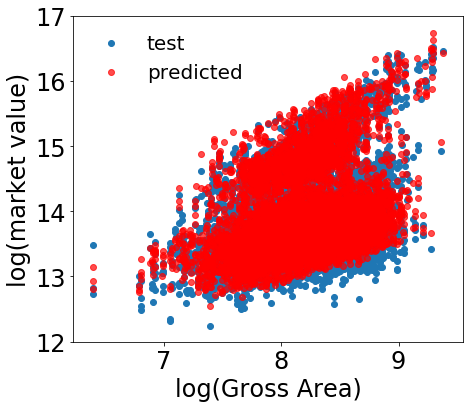

In [20]:
fig = plt.figure(figsize=(7,6))
plt.scatter(X_test["GROSS_AREA"],Y_test,label="test",alpha=1.0)
plt.scatter(X_test["GROSS_AREA"],ElasticNetCVModel2.predict(X_test[all_features]),color="red",label="predicted",alpha=0.7)
plt.xticks([7.0,8.0,9.0],size=24)
plt.yticks(size=24)
plt.xlabel("log(Gross Area)",size=24)
plt.ylabel("log(market value)",size=24)
plt.legend(prop={'size': 20},frameon=False)
plt.savefig("Model2_AreaVsMV.png",bbox_inches="tight",dpi=300)

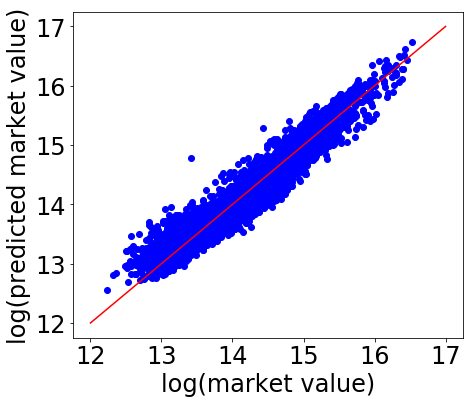

In [21]:
fig = plt.figure(figsize=(7,6))
plt.scatter(Y_test,ElasticNetCVModel2.predict(X_test[all_features]),color="blue")
plt.plot([12,17],[12,17],"-",color="red")
plt.xticks([12,13,14,15,16,17],size=24)
plt.yticks([12,13,14,15,16,17],size=24)
plt.ylabel("log(predicted market value)",size=24)
plt.xlabel("log(market value)",size=24)
#plt.legend(prop={'size': 20},frameon=False)
plt.savefig("test_predictMV.png",bbox_inches="tight",dpi=300)

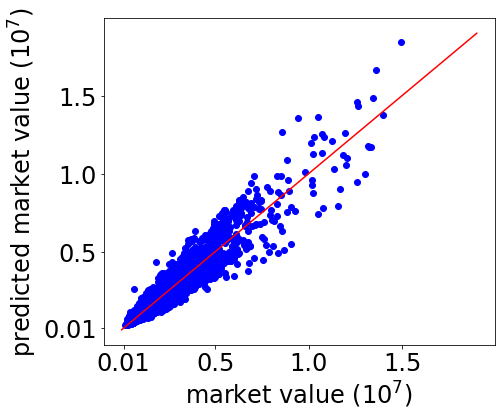

In [22]:
fig = plt.figure(figsize=(7,6))
plt.scatter(np.exp(Y_test),np.exp(ElasticNetCVModel2.predict(X_test[all_features])),color="blue")
plt.plot([0,1.9e7],[0,1.9e7],"-",color="red")
plt.xticks([0.01e7,0.50e7,1.00e7,1.5e7],["0.01","0.5","1.0","1.5"],size=24)
plt.yticks([0.01e7,0.50e7,1.00e7,1.5e7],["0.01","0.5","1.0","1.5"],size=24)
#plt.plot([12,17],[12,17],"-",color="red")
plt.ylabel("predicted market value $(10^7)$",size=24)
plt.xlabel("market value $(10^7)$",size=24)
#plt.legend(prop={'size': 20},frameon=False)
plt.savefig("test_predictMV_NOLOG.png",bbox_inches="tight",dpi=300)

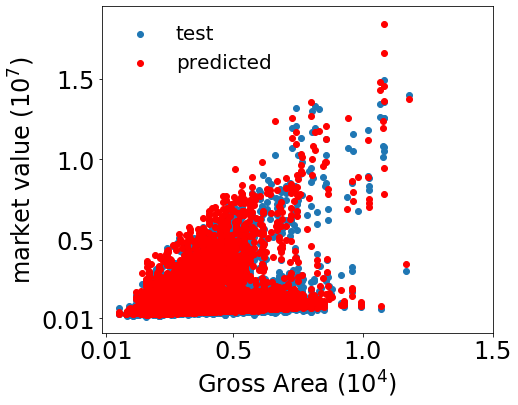

In [23]:
fig = plt.figure(figsize=(7,6))
plt.scatter(np.exp(X_test["GROSS_AREA"].values),np.exp(Y_test.values),label="test")
plt.scatter(np.exp(X_test["GROSS_AREA"].values),np.exp(ElasticNetCVModel2.predict(X_test[all_features])),color="red",label="predicted")
plt.xticks([0.01e4,0.50e4,1.00e4,1.5e4],["0.01","0.5","1.0","1.5"],size=24)
plt.yticks([0.01e7,0.50e7,1.00e7,1.5e7],["0.01","0.5","1.0","1.5"],size=24)

plt.xlabel("Gross Area $(10^4)$",size=24)
plt.ylabel("market value $(10^7)$",size=24)
plt.legend(prop={'size': 20},frameon=False)
plt.savefig("Model2_AreaVsMV_UnLog.png",bbox_inches="tight",dpi=300)

In [24]:
from scipy.stats.stats import pearsonr
print("pearson correlation between truth and predicted values = ", pearsonr(np.exp(Y_test),np.exp(ElasticNetCVModel2.predict(X_test[all_features]))))

pearson correlation between truth and predicted values =  (0.9608653199118243, 0.0)


# Find out-liers and check renovation potential 

In [25]:
ndata = data.copy(deep=True); 
ndata.columns

Index(['key', 'PTYPE', 'LAND_SF', 'YR_BUILT', 'YR_REMOD', 'GROSS_AREA',
       'LIVING_AREA', 'NUM_FLOORS', 'R_TOTAL_RMS', 'R_BDRMS',
       ...
       'R_INT_CND_G', 'R_INT_CND_P', 'R_INT_FIN_E', 'R_INT_FIN_N',
       'R_INT_FIN_S', 'R_VIEW_A', 'R_VIEW_E', 'R_VIEW_F', 'R_VIEW_G',
       'R_VIEW_P'],
      dtype='object', length=106)

In [26]:
ndata["Residual"] = np.exp(ndata["MARKET_VALUE"]) - np.exp(ElasticNetCVModel2.predict(ndata[all_features]))
RSS = (ndata["Residual"]**2).sum()/len(ndata)
print("root mean square error =", np.sqrt(RSS))
print("mean absolute error = ", np.abs(ndata["Residual"]).mean())
#print("standard deviation = ", np.abs(ndata["Residual"].values).std())

root mean square error = 353015.6606519691
mean absolute error =  188734.28101150287


/home/npatel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':


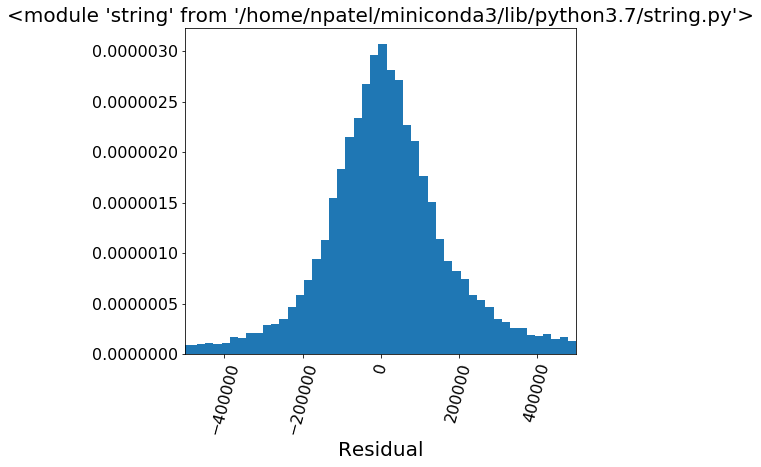

In [27]:
from scipy.stats import norm
xmin=-500000
xmax=500000
sigma_scale=0.34
mean=ndata["Residual"].mean()
std = ndata["Residual"].std()

fig = plt.figure(figsize=(7,6))
plt.hist(ndata["Residual"],bins=400, normed=True); 
#x = np.linspace(xmin, xmax, 100)
#y = norm.pdf(x, mean, std*sigma_scale)
#plt.plot(x, y,color="red",lw=2)

#string = "mean = 14.5k \n standard deviation = 110k"; 
plt.title(string,size=20)
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlabel("Residual",size=20)
#plt.ylabel("zestimate - log(market value)",size=16)

plt.xlim(left=-0.5e6,right=0.5e6)
plt.xticks(rotation=75)
plt.savefig("Model2_Residual.png",bbox_inches="tight",dpi=300)
plt.show()

In [28]:
recommend = ndata[(ndata["Residual"]<-115000) & (ndata["Residual"]>-400000)]

In [29]:
recommend = recommend[(recommend["key"]==2019) & recommend["YR_REMOD"]!=0]

In [30]:
recommend

,key,PTYPE,LAND_SF,YR_BUILT,YR_REMOD,GROSS_AREA,LIVING_AREA,NUM_FLOORS,R_TOTAL_RMS,R_BDRMS,...,R_INT_CND_P,R_INT_FIN_E,R_INT_FIN_N,R_INT_FIN_S,R_VIEW_A,R_VIEW_E,R_VIEW_F,R_VIEW_G,R_VIEW_P,Residual
88,2019,101.0,1701.0,1890.0,2004.0,8.473868,8.219057,3.5,14.0,5.0,...,0,1,0,0,1,0,0,0,0,-132293.418222
480,2019,101.0,1750.0,1837.0,2016.0,8.459564,8.306472,3.5,12.0,4.0,...,0,1,0,0,1,0,0,0,0,-339234.710328
528,2019,101.0,1587.0,1890.0,2009.0,7.976595,7.976595,2.0,8.0,4.0,...,0,1,0,0,1,0,0,0,0,-250189.243764
912,2019,101.0,2000.0,1830.0,2015.0,8.942199,8.802973,4.5,13.0,3.0,...,0,1,0,0,1,0,0,0,0,-317983.704049
1920,2019,101.0,5000.0,1980.0,1999.0,8.325791,7.869402,2.0,10.0,4.0,...,0,0,1,0,0,1,0,0,0,-286288.001047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30451,2019,101.0,5607.0,1955.0,2008.0,7.863267,7.146772,1.0,6.0,3.0,...,0,0,1,0,0,0,0,1,0,-196523.717686
30459,2019,104.0,4312.0,1925.0,2010.0,8.335431,7.795647,2.0,10.0,4.0,...,0,0,1,0,1,0,0,0,0,-117609.587969
30539,2019,104.0,16025.0,1920.0,2011.0,8.941676,8.445697,2.5,10.0,6.0,...,0,0,1,0,1,0,0,0,0,-208869.243247
30635,2019,101.0,3078.0,1929.0,1984.0,7.865955,7.452982,2.0,8.0,3.0,...,0,0,1,0,1,0,0,0,0,-128227.191294


In [31]:
import scipy.stats as scs
y = ndata["Residual"]
a, b, loc, scale = scs.johnsonsu.fit(y) # fit the data and get distribution parameters back

# distribution mean and variance according to SciPy
dist_mean = scs.johnsonsu.mean(a, b, loc, scale)
dist_med  = scs.johnsonsu.median(a, b, loc, scale)
dist_var  = scs.johnsonsu.var(a, b, loc, scale)
print(dist_mean, dist_med, dist_var, np.sqrt(dist_var))

25569.644583589055 9589.481842176154 156716965027.58743 395874.93609420065


## Cleaned up Run

In [32]:
# Load in the data
df3 = pd.read_csv("downsized_7.csv")
df['PTYPE'] = df['PTYPE'].astype('O')

# important features
myfeat = ['key', 'PTYPE',
       'LU', 'OWN_OCC', 'LAND_SF', 'YR_BUILT', 'YR_REMOD', 'GROSS_AREA', 'LIVING_AREA', 'NUM_FLOORS',
       'R_BLDG_STYL', 'R_ROOF_TYP', 'R_EXT_FIN', 'R_TOTAL_RMS', 'R_BDRMS',
       'R_FULL_BTH', 'R_HALF_BTH', 'R_BTH_STYLE', 'R_KITCH', 'R_KITCH_STYLE',
       'R_HEAT_TYP', 'R_AC', 'R_FPLACE', 'R_EXT_CND', 'R_OVRALL_CND',
       'R_INT_CND', 'R_INT_FIN', 'R_VIEW', 'R_TOTAL_BTH','MARKET_VALUE', "ZIP_MV",
        'DIS0', 'DIS1', 'DIS2', 'DIS3', 'DIS4', 'DIS5']

# features for one-hot-encoding
dumFeat = ['LU', 'R_BLDG_STYL', 'R_ROOF_TYP',
        'R_EXT_FIN', 'R_BTH_STYLE', 'R_KITCH_STYLE', 'R_HEAT_TYP', 'R_AC',
        'R_EXT_CND', 'R_OVRALL_CND', 'R_INT_CND', 'R_INT_FIN', 'R_VIEW', "PTYPE"]
df3 = pd.get_dummies(df3,columns=dumFeat)

all_features = df3.columns
index = np.argwhere(myfeat=="MARKET_VALUE")
all_features = np.delete(myfeat, index)
target_feature = "MARKET_VALUE"

my_feat = ['LU_R1', 'LU_R2', 'LU_R3', 'R_BLDG_STYL_BW', 'R_BLDG_STYL_CL',
        'R_BLDG_STYL_CN', 'R_BLDG_STYL_CP', 'R_BLDG_STYL_CV', 'R_BLDG_STYL_DK',
        'R_BLDG_STYL_DX', 'R_BLDG_STYL_OT', 'R_BLDG_STYL_RE', 'R_BLDG_STYL_RM',
        'R_BLDG_STYL_RN', 'R_BLDG_STYL_RR', 'R_BLDG_STYL_SD', 'R_BLDG_STYL_SL',
        'R_BLDG_STYL_TD', 'R_BLDG_STYL_TF', 'R_BLDG_STYL_TL', 'R_BLDG_STYL_VT',
        'R_ROOF_TYP_F', 'R_ROOF_TYP_G', 'R_ROOF_TYP_H', 'R_ROOF_TYP_L',
        'R_ROOF_TYP_M', 'R_ROOF_TYP_S', 'R_EXT_FIN_A', 'R_EXT_FIN_B',
        'R_EXT_FIN_C', 'R_EXT_FIN_F', 'R_EXT_FIN_G', 'R_EXT_FIN_M',
        'R_EXT_FIN_O', 'R_EXT_FIN_P', 'R_EXT_FIN_S', 'R_EXT_FIN_U',
        'R_EXT_FIN_V', 'R_EXT_FIN_W', 'R_BTH_STYLE_L', 'R_BTH_STYLE_M',
        'R_BTH_STYLE_N', 'R_BTH_STYLE_S', 'R_KITCH_STYLE_L', 'R_KITCH_STYLE_M',
        'R_KITCH_STYLE_N', 'R_KITCH_STYLE_S', 'R_HEAT_TYP_E', 'R_HEAT_TYP_F',
        'R_HEAT_TYP_N', 'R_HEAT_TYP_O', 'R_HEAT_TYP_P', 'R_HEAT_TYP_S',
        'R_HEAT_TYP_W', 'R_AC_C', 'R_AC_D', 'R_AC_N', 'R_AC_Y', 'R_EXT_CND_A',
        'R_EXT_CND_E', 'R_EXT_CND_F', 'R_EXT_CND_G', 'R_EXT_CND_P',
        'R_OVRALL_CND_A', 'R_OVRALL_CND_E', 'R_OVRALL_CND_F', 'R_OVRALL_CND_G',
        'R_OVRALL_CND_P', 'R_INT_CND_A', 'R_INT_CND_E', 'R_INT_CND_F',
        'R_INT_CND_G', 'R_INT_CND_P', 'R_INT_FIN_E', 'R_INT_FIN_N',
        'R_INT_FIN_S', 'R_VIEW_A', 'R_VIEW_E', 'R_VIEW_F', 'R_VIEW_G',
        'R_VIEW_P', 'PTYPE_101.0', 'PTYPE_104.0', 'PTYPE_105.0',
           'OWN_OCC','LAND_SF', 'YR_BUILT', 'YR_REMOD', 'GROSS_AREA', 'LIVING_AREA',
        'NUM_FLOORS', 'R_TOTAL_RMS', 'R_BDRMS', 'R_FULL_BTH', 'R_HALF_BTH',
        'R_KITCH', 'R_FPLACE', 'R_TOTAL_BTH', 'DIS0', 'DIS1',
        'DIS2', 'DIS3', 'DIS4', 'DIS5', 'ZIP_MV','key']
target_feat = "MARKET_VALUE"

In [33]:
# keeping all the 2019 data into test-set 
data19 = df3[df3["key"]==2019]
data18 = df3[df3["key"]!=2019]

# 80/20 test train split on 2010-2018 data. 
X_train, X_test, Y_train, Y_test = train_test_split(data18[my_feat], data18[target_feat], test_size=0.2, random_state=1)

# append 2019 test data into X_test and Y_test
X_test = X_test.append(data19[my_feat]);
Y_test = Y_test.append(data19[target_feature]); 

# ElasticNet 
from sklearn.linear_model import ElasticNetCV

# Reduced eps to 10^-4 
# Remember to always normalize!
ElasticNetCVModel2 = ElasticNetCV(l1_ratio=[1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1], 
                                  eps=0.0001, n_alphas=50, normalize=True, random_state=1,
                                  verbose=True, max_iter=1000)

# Fitting on train data with cross-validation.  
ElasticNetCVModel2.fit(X_train,Y_train)

# does the weights make sense? - Looks reasonable
# L1 reguralization is working well for feature importance!
coef_val = pd.Series(ElasticNetCVModel2.coef_,my_feat)
print(coef_val.sort_values(ascending=False))

/home/npatel/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

ZIP_MV             0.770434
LIVING_AREA        0.294291
R_VIEW_E           0.226665
R_EXT_FIN_G        0.199217
GROSS_AREA         0.154454
R_BLDG_STYL_OT     0.109179
R_BLDG_STYL_TD     0.098347
R_VIEW_G           0.097140
R_INT_FIN_E        0.096286
DIS5               0.093243
R_INT_CND_E        0.076580
R_BLDG_STYL_CN     0.073506
R_BLDG_STYL_SL     0.053529
R_EXT_FIN_C        0.052733
R_FULL_BTH         0.045815
R_BLDG_STYL_RE     0.045609
R_ROOF_TYP_M       0.043094
DIS2               0.037426
R_HEAT_TYP_P       0.037123
LU_R1              0.035896
key                0.034365
R_EXT_FIN_S        0.034159
R_BLDG_STYL_RN     0.033536
NUM_FLOORS         0.033155
R_HALF_BTH         0.031658
R_BLDG_STYL_RM     0.029580
R_EXT_FIN_W        0.025619
R_KITCH_STYLE_M    0.023839
R_EXT_FIN_V        0.023419
R_EXT_CND_G        0.019477
R_KITCH_STYLE_L    0.019061
R_BLDG_STYL_SD     0.018687
R_BLDG_STYL_CP     0.017756
R_FPLACE           0.015068
R_ROOF_TYP_H       0.013706
R_BLDG_STYL_VT     0

In [34]:
print("train R^2 = ", ElasticNetCVModel2.score(X_train,Y_train))
print("test R^2 = ", ElasticNetCVModel2.score(X_test,Y_test))
print("L1_ratio = ", ElasticNetCVModel2.l1_ratio_)
#stdev = np.sqrt(sum((ElasticNetCVModel2.predict(X_train) - Y_train)**2) / (len(Y_train) - 2))
#print(stdev, np.exp(stdev))

train R^2 =  0.9257712932697703
test R^2 =  0.9199525297388327
L1_ratio =  1.0


# Important features

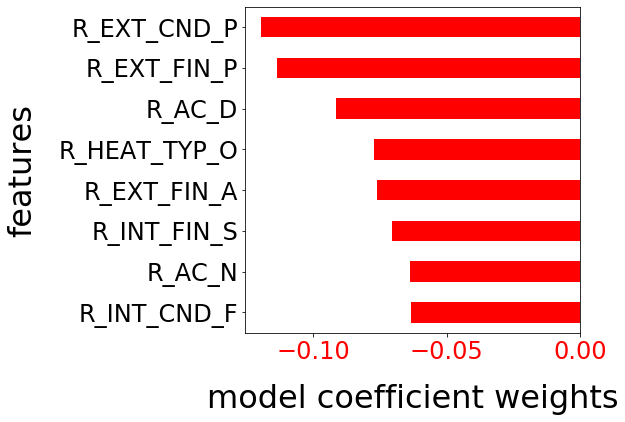

In [35]:
temper = coef_val.drop(labels = ['DIS0', 'DIS1', "DIS2", "DIS3", "DIS4", "DIS5","ZIP_MV",
                                 "LIVING_AREA","R_VIEW_E","R_VIEW_G","GROSS_AREA",
                                 "R_BLDG_STYL_OT","R_BLDG_STYL_TD","R_BLDG_STYL_CN",
                                 "R_BLDG_STYL_SL","R_BLDG_STYL_RE","R_BLDG_STYL_RN"]) 

# plot negatively weighed features
plt.figure(figsize=(6,6))

temper = temper.sort_values(ascending=False)
temper[temper<-0.06].plot.barh(color="red")
plt.xticks(rotation=90)

plt.yticks(size=24)
plt.xlabel("model coefficient weights",size=32,labelpad=20)
plt.ylabel("features",size=32,labelpad=20)

plt.xticks([-0.1,-0.05,0],size=24,rotation=0,color="red")
#plt.xlim(left=-0.5e6,right=0.5e6)
plt.savefig("coef_neg.png",bbox_inches="tight",dpi=300)
plt.show()

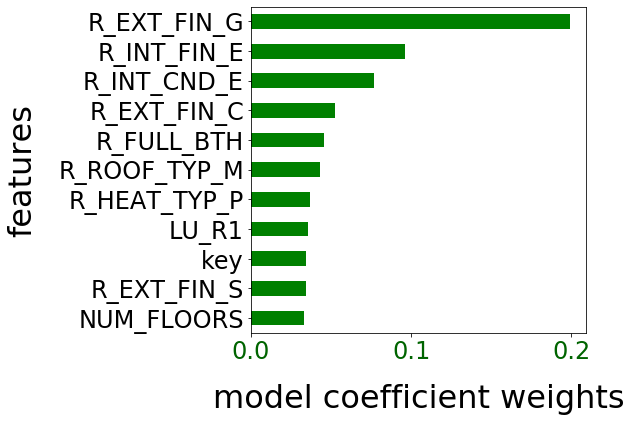

In [36]:
# plot positively weighed features
plt.figure(figsize=(6,6))

temper = temper.sort_values(ascending=True)
temper[temper>0.032].plot.barh(color="green")
plt.xticks(rotation=90)

plt.yticks(size=24)
plt.xlabel("model coefficient weights",size=32,labelpad=20)
plt.ylabel("features",size=32,labelpad=20)

plt.xticks([0,0.1,0.2],size=24,rotation=0,color="darkgreen")
#plt.xlim(left=-0.5e6,right=0.5e6)
plt.savefig("coef_pos.png",bbox_inches="tight",dpi=300)
plt.show()

In [37]:
df3["Residual"] =  -np.exp(ElasticNetCVModel2.predict(df3[my_feat])) + np.exp(df3["MARKET_VALUE"])
RSS = (df3["Residual"]**2).sum()/len(ndata)
print(np.sqrt(RSS))

353031.857465295


# Appendix - some raw querys for renovations

## Query houses with specific renovations

In [38]:
recommend = df3[(df3["Residual"]<-100000)]
recommend = recommend[(recommend["key"]==2019) & recommend["YR_REMOD"]!=0]
recommend = recommend[recommend["R_EXT_FIN_P"]==1]
print(recommend["FULLADD"])
query = recommend.iloc[2]

17881       60 FOWLER ST Boston, MA 2121
18857    6 NOTTINGHAM ST Boston, MA 2121
22351     2.0 LEONARD CT Boston, MA 2122
Name: FULLADD, dtype: object


### Renovation: Asphalt exterior finish to Glass exerior finish

In [39]:
query.at["R_EXT_FIN_G"] = 1
query.at["R_EXT_FIN_P"] = 0
np.exp(ElasticNetCVModel2.predict(query[my_feat].values.reshape(1,-1))[0])

682304.753150607

In [40]:
recommend = df3[(df3["Residual"]<-200000)]
recommend = recommend[(recommend["key"]==2019)]
recommend = recommend[recommend["R_EXT_FIN_P"]==1]
print(recommend["FULLADD"])

18497    2 OTISFIELD ST Boston, MA 2121
Name: FULLADD, dtype: object


In [41]:
np.exp(ElasticNetCVModel2.predict(query[my_feat].values.reshape(1,-1))[0])

682304.753150607

In [42]:
query.at["R_EXT_FIN_G"] = 1
query.at["R_EXT_FIN_P"] = 0
np.exp(ElasticNetCVModel2.predict(query[my_feat].values.reshape(1,-1))[0])

682304.753150607

In [43]:
outputdf = pd.DataFrame(columns=["PID","FULLADD","MARKET_VALUE","R_EXT_FIN_P","R_EXP_FIN_E","Profit_wo_Renocost"])
for index, val in recommend.iterrows(): 
    mv = np.exp(val["MARKET_VALUE"]); 
    val.at["R_EXT_FIN_P"]=0; 
    val.at["R_EXT_FIN_E"]=1; 
    newmv19 = np.exp(ElasticNetCVModel2.predict(query[my_feat].values.reshape(1,-1))[0])
    
    val.at["key"]=2020 
    newmv20 = np.exp(ElasticNetCVModel2.predict(query[my_feat].values.reshape(1,-1))[0])
    
    print(mv, newmv19, newmv20, newmv19-mv, newmv20-mv)

415143.08716122137 682304.753150607 682304.753150607 267161.6659893856 267161.6659893856


In [44]:
recommend = df3[(df3["key"]==2019)]
recommend = recommend[recommend["R_EXT_FIN_P"]==1]
#print(recommend["FULLADD"])

recommend["MVReno19"] = 0.0; 
recommend["MVReno20"] = 0.0; 
recommend["Prof19"] = 0.0; 
recommend["Prof20"] = 0.0; 
for index, val in recommend.iterrows(): 
    mv = np.exp(val["MARKET_VALUE"]); 
    val.at["R_EXT_FIN_P"]=0; 
    val.at["R_EXT_FIN_G"]=1; 
    newmv19 = np.exp(ElasticNetCVModel2.predict(val[my_feat].values.reshape(1,-1))[0])
    
    val.at["key"]=2020 
    newmv20 = np.exp(ElasticNetCVModel2.predict(val[my_feat].values.reshape(1,-1))[0])
    
    recommend.at[index,"MARKET_VALUE"]=mv
    recommend.at[index,"MVReno19"]=newmv19
    recommend.at[index,"MVReno20"]=newmv20
    recommend.at[index,"Prof19"] = newmv19-mv
    recommend.at[index,"Prof20"] = newmv20-mv
    
recommend = recommend.sort_values(by="Prof19",ascending=False)

In [45]:
interFeat = ["FULLADD","MARKET_VALUE", "MVReno19","MVReno20",'Prof19','Prof20']
print(recommend[interFeat]); 

                                   FULLADD  MARKET_VALUE      MVReno19  \
18497       2 OTISFIELD ST Boston, MA 2121  4.151431e+05  9.131750e+05   
19137       176 RUTHVEN ST Boston, MA 2121  7.722899e+05  1.243135e+06   
18857      6 NOTTINGHAM ST Boston, MA 2121  6.082886e+05  1.018211e+06   
17881         60 FOWLER ST Boston, MA 2121  6.544766e+05  1.056481e+06   
18593        9 WAUMBECK ST Boston, MA 2121  7.943023e+05  1.195501e+06   
13595        37 LINDSEY ST Boston, MA 2124  8.397735e+05  1.229149e+06   
21559         40 WINTER ST Boston, MA 2122  6.819866e+05  1.070231e+06   
18889          29 WABON ST Boston, MA 2121  9.822448e+05  1.364057e+06   
9207          3 PULASKI AV Boston, MA 2127  5.418925e+05  9.195176e+05   
22367   14.0 LEEDSVILLE ST Boston, MA 2122  7.272626e+05  1.101684e+06   
5345   169 N WASHINGTON ST Boston, MA 2113  9.542401e+05  1.316049e+06   
17937        23 HOLBORN ST Boston, MA 2121  7.036108e+05  1.056894e+06   
22351       2.0 LEONARD CT Boston, MA 

### Renovating house style to Tudor - most expensive!

In [46]:
BuildStylFeat = ['R_BLDG_STYL_BW', 'R_BLDG_STYL_CL',
        'R_BLDG_STYL_CN', 'R_BLDG_STYL_CP', 'R_BLDG_STYL_CV', 'R_BLDG_STYL_DK',
        'R_BLDG_STYL_DX', 'R_BLDG_STYL_OT', 'R_BLDG_STYL_RE', 'R_BLDG_STYL_RM',
        'R_BLDG_STYL_RN', 'R_BLDG_STYL_RR', 'R_BLDG_STYL_SD', 'R_BLDG_STYL_SL',
        'R_BLDG_STYL_TD', 'R_BLDG_STYL_TF', 'R_BLDG_STYL_TL', 'R_BLDG_STYL_VT']

In [47]:
recommend = df3[(df3["key"]==2019)]
print(len(recommend))
recommend = recommend[(recommend["R_BLDG_STYL_TD"]==0) & (recommend["R_BLDG_STYL_OT"]==0)]
print(len(recommend))
#print(recommend["FULLADD"])

recommend[BuildStylFeat] = 0;
recommend["R_BLDG_STYL_TD"] = 1;
recommend["MARKET_VALUE"] = np.exp(recommend["MARKET_VALUE"]); 
recommend["MVReno19"] = np.exp(ElasticNetCVModel2.predict(recommend[my_feat])); 
recommend["key"] = 2020;
recommend["MVReno20"] = np.exp(ElasticNetCVModel2.predict(recommend[my_feat])); 
recommend["Prof19"] = recommend["MVReno19"] - recommend["MARKET_VALUE"]; 
recommend["Prof20"] = recommend["MVReno20"] - recommend["MARKET_VALUE"]; 

recommend = recommend.sort_values(by="Prof19",ascending=False)

3542
3532


In [48]:
interFeat = ["FULLADD","MARKET_VALUE", "MVReno19","MVReno20",'Prof19','Prof20']
print(recommend[interFeat]); 

                                  FULLADD  MARKET_VALUE      MVReno19  \
240         39 BRIMMER ST Boston, MA 2108  9.461538e+06  1.456730e+07   
712          34 BEACON ST Boston, MA 2108  1.496651e+07  1.945554e+07   
448      100 MT VERNON ST Boston, MA 2108  7.084783e+06  1.056313e+07   
336          7 BRIMMER ST Boston, MA 2108  6.942107e+06  1.004217e+07   
384          60 BEACON ST Boston, MA 2108  1.026668e+07  1.326514e+07   
...                                   ...           ...           ...   
8214    59 MARLBOROUGH ST Boston, MA 2116  6.742828e+06  4.017319e+06   
8166  129 COMMONWEALTH AV Boston, MA 2116  1.157875e+07  8.507619e+06   
8685   390 MARLBOROUGH ST Boston, MA 2115  8.363997e+06  5.243794e+06   
7886   113 MARLBOROUGH ST Boston, MA 2116  9.042281e+06  5.899162e+06   
8126          7 EXETER ST Boston, MA 2116  8.686188e+06  5.384027e+06   

          MVReno20        Prof19        Prof20  
240   1.507660e+07  5.105762e+06  5.615067e+06  
712   2.013575e+07  4.489

In [49]:
len(my_feat)

106

### Renovation: Interior condition (anything) to excellent 

In [50]:
BuildStylFeat = ['R_INT_CND_A', 'R_INT_CND_E', 'R_INT_CND_F','R_INT_CND_G', 'R_INT_CND_P']

In [51]:
recommend = df3[(df3["key"]==2019) & (df3["Residual"]<-100000)]
print(len(recommend))
recommend = recommend[(recommend["R_INT_CND_E"]!=1)]
print(len(recommend))
#print(recommend["FULLADD"])

recommend[BuildStylFeat] = 0;
recommend["R_INT_CND_E"] = 1;
recommend["MARKET_VALUE"] = np.exp(recommend["MARKET_VALUE"]); 
recommend["MVReno19"] = np.exp(ElasticNetCVModel2.predict(recommend[my_feat])); 
recommend["key"] = 2020;
recommend["MVReno20"] = np.exp(ElasticNetCVModel2.predict(recommend[my_feat])); 
recommend["Prof19"] = recommend["MVReno19"] - recommend["MARKET_VALUE"]; 
recommend["Prof20"] = recommend["MVReno20"] - recommend["MARKET_VALUE"]; 

recommend = recommend.sort_values(by="Prof19",ascending=False)

808
763


In [52]:
interFeat = ["FULLADD","MARKET_VALUE", "MVReno19","MVReno20",'Prof19','Prof20']
recommend = recommend[recommend["Prof19"]<1e6]
print(recommend[interFeat]);

                                  FULLADD  MARKET_VALUE      MVReno19  \
7854   24 S HUNTINGTON AV Boston, MA 2116  1.950355e+06  2.943181e+06   
24           29 BRANCH ST Boston, MA 2108  2.374465e+06  3.365827e+06   
6168     123 W CONCORD ST Boston, MA 2118  2.307018e+06  3.280900e+06   
992           10 BYRON ST Boston, MA 2108  4.843269e+06  5.816949e+06   
9167      10.0 KESWICK ST Boston, MA 2215  2.571564e+06  3.527632e+06   
...                                   ...           ...           ...   
14067         27 LOGAN ST Boston, MA 2119  4.775914e+05  6.433202e+05   
25114     5.0 FENSMERE RD Boston, MA 2132  7.749860e+05  9.402835e+05   
16065        38 SUSSEX ST Boston, MA 2120  5.437526e+05  7.055402e+05   
23642      30 STARBIRD AV Boston, MA 2131  4.866902e+05  6.482041e+05   
11014         7.0 KANE ST Boston, MA 2125  6.401092e+05  7.950213e+05   

           MVReno20         Prof19        Prof20  
7854   3.046082e+06  992826.875000  1.095727e+06  
24     3.483504e+06  